<a href="https://colab.research.google.com/github/9-coding/Mathematics/blob/main/stochastic_mini_batch_mse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

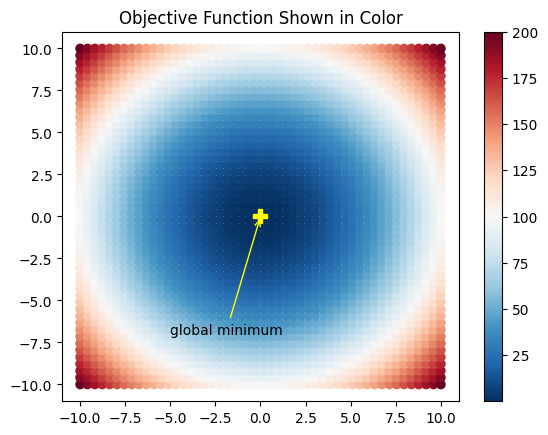

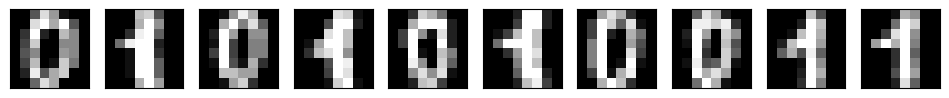

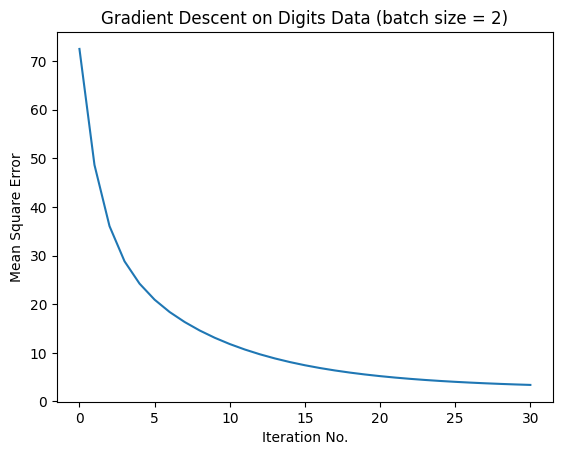

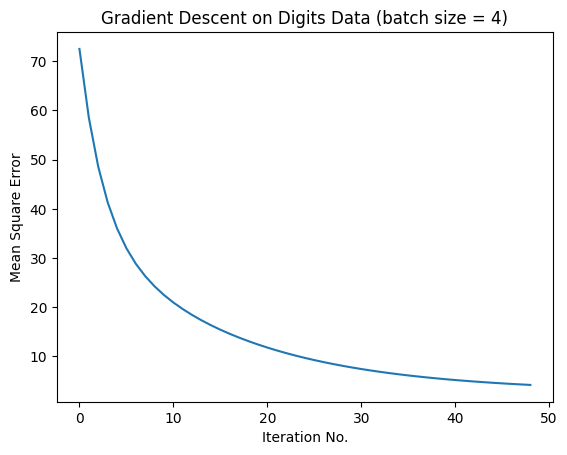

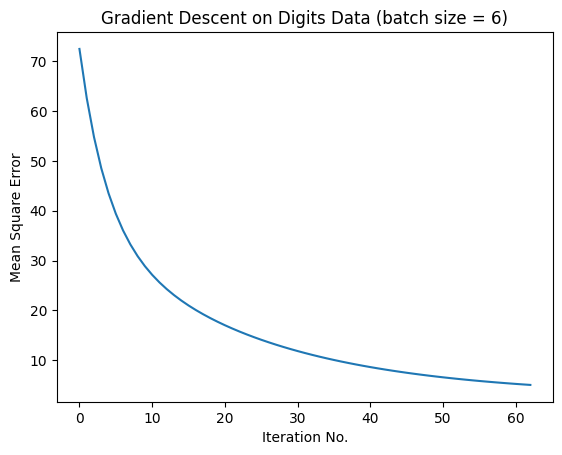

In [1]:
# AI_Mathematics_0515 KooDoYeon

# Reference: https://stackabuse.com/gradient-descent-in-python-implementation-and-theory/
# Code to determine how the mse graph depends on how much the batch size is in the stochastic gradient descent.

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.datasets as dt
from sklearn.model_selection import train_test_split

# Make threshold a -ve value if you want to run exactly
# max_iterations.


# visualision_fw() function : generates 2500 points at equal intervals and calculates the function value at each point.
def visualize_fw():
    xcoord = np.linspace(-10.0,10.0,50)
    ycoord = np.linspace(-10.0,10.0,50)
    w1,w2 = np.meshgrid(xcoord,ycoord)
    pts = np.vstack((w1.flatten(),w2.flatten()))
    
    # All 2D points on the grid
    pts = pts.transpose()
    
    # Function value at each point
    f_vals = np.sum(pts*pts,axis=1)
    function_plot(pts,f_vals)
    plt.title('Objective Function Shown in Color')
    plt.show()
    return pts,f_vals

# Helper function to annotate a single point
# Visualize points through color and text
def annotate_pt(text,xy,xytext,color):
    plt.plot(xy[0],xy[1],marker='P',markersize=10,c=color)
    plt.annotate(text,xy=xy,xytext=xytext,
                 arrowprops=dict(arrowstyle="->",
                 color = color,
                 connectionstyle='arc3'))

# function_plot() function : displays all points in different colors depending on the f(w) value of the point.
def function_plot(pts,f_val):
    f_plot = plt.scatter(pts[:,0],pts[:,1],
                         c=f_val,vmin=min(f_val),vmax=max(f_val),
                         cmap='RdBu_r')
    plt.colorbar(f_plot)
    # Show the optimal point
    annotate_pt('global minimum',(0,0),(-5,-7),'yellow')    

pts,f_vals = visualize_fw()


# Running Gradient Descent with Different Hyper-parameters

# Objective function
def f(w,extra=[]):
    return np.sum(w*w)

# Function to compute the gradient
def grad(w,extra=[]):
    return 2*w

# Function to plot the objective function
# and learning history annotated by arrows
# to show how learning proceeded
# The arrows on the graph allow you to easily track the last updated point
def visualize_learning(w_history):  
    
    # Make the function plot
    function_plot(pts,f_vals)
    
    # Plot the history
    plt.plot(w_history[:,0],w_history[:,1],marker='o',c='magenta') 
    
    # Annotate the point found at last iteration
    annotate_pt('minimum found',
                (w_history[-1,0],w_history[-1,1]),
                (-1,7),'green')
    iter = w_history.shape[0]    


#Gradient Descent for Minimizing Mean Square Error

# Input argument is weight and a tuple (train_data, target)
def grad_mse(w,xy):
    (x,y) = xy
    (rows,cols) = x.shape
    
    # Compute the output
    o = np.sum(x*w,axis=1)
    diff = y-o
    diff = diff.reshape((rows,1))    
    diff = np.tile(diff, (1, cols))
    grad = diff*x
    grad = -np.sum(grad,axis=0)
    return grad

# Input argument is weight and a tuple (train_data, target)
def mse(w,xy):
    (x,y) = xy
    
    # Compute output
    # keep in mind that wer're using mse and not mse/m
    # because it would be relevant to the end result
    o = np.sum(x*w,axis=1)
    mse = np.sum((y-o)*(y-o))
    mse = mse/2
    return mse    



# Running Gradient Descent on OCR

# Load the digits dataset with two classes
digits,target = dt.load_digits(n_class=2,return_X_y=True)
fig,ax = plt.subplots(nrows=1, ncols=10,figsize=(12,4),subplot_kw=dict(xticks=[], yticks=[]))

# Plot some images of digits
for i in np.arange(10):
    ax[i].imshow(digits[i,:].reshape(8,8),cmap=plt.cm.gray)   
plt.show()

# Split into train and test set
x_train, x_test, y_train, y_test = train_test_split(
                        digits, target, test_size=0.2, random_state=10)

# Add a column of ones to account for bias in train and test
x_train = np.hstack((np.ones((y_train.size,1)),x_train))
x_test  = np.hstack((np.ones((y_test.size,1)),x_test))


# Function that calculates the record of the mini batch of stochastic gradient decents
def mini_batch_gradient_descent(max_epochs, threshold, w_init,
                                obj_func, grad_func, xy, batch_size,
                                learning_rate=0.05, momentum=0.8):
    (x_train, y_train) = xy
    w = w_init
    w_history = w
    f_history = obj_func(w, xy)
    delta_w = np.zeros(w.shape)
    i = 0
    diff = 1.0e10
    rows = x_train.shape[0]

    # Run epochs
    while i < max_epochs and diff > threshold:
        # Shuffle rows using a fixed seed to reproduce the results
        np.random.seed(i)
        p = np.random.permutation(rows)
        # Split shuffled data into mini-batches
        mini_batches = [p[k:k + batch_size] for k in range(0, rows, batch_size)]

        # Run for each mini-batch
        for n in mini_batches:
            x_mini_batch = x_train[n]
            y_mini_batch = y_train[n]

            delta_w = np.zeros(w.shape)
            # Run for each instance in mini-batch
            for x, y in zip(x_mini_batch, y_mini_batch):
                delta_w -= learning_rate * grad_func(w, (np.array([x]), y))
            delta_w /= batch_size
            delta_w + momentum * delta_w
            w += delta_w

        i += 1
        w_history = np.vstack((w_history, w))
        f_history = np.vstack((f_history, obj_func(w, xy)))
        diff = np.absolute(f_history[-1] - f_history[-2])
    return w_history, f_history


def mini_batch(max_epochs,threshold,w_init,
                                obj_func,grad_func,xy,batch_size,
                                learning_rate=0.05,momentum=0.8):
    (x_train,y_train) = xy
    w = w_init
    w_history = w
    f_history = obj_func(w,xy)
    delta_w = np.zeros(w.shape)
    i = 0
    diff = 1.0e10
    rows = x_train.shape[0]
    
    # Run epochs
    while  i<max_epochs and diff>threshold:
        # Shuffle rows using a fixed seed to reproduce the results
        np.random.seed(i)
        p = np.random.permutation(rows)
        
        # Run for each instance/example in training set
        for x,y in zip(x_train[p,:],y_train[p]):
            delta_w = -learning_rate*grad_func(w,(np.array([x]),y))
            w = w+delta_w + momentum*delta_w
            
        i+=1
        w_history = np.vstack((w_history,w))
        f_history = np.vstack((f_history,obj_func(w,xy)))
        diff = np.absolute(f_history[-1]-f_history[-2])
        
    return w_history,f_history

# Plot the MSE
rand = np.random.RandomState(19)
w_init = rand.uniform(-1,1,x_train.shape[1])*.000001
w_history_stoch,mini_batch_mse_history_stoch1 = mini_batch_gradient_descent(
                                100,0.1,w_init,
                              mse,grad_mse,(x_train,y_train),2,
                             learning_rate=1e-6,momentum=0.7)


rand = np.random.RandomState(19)
w_init = rand.uniform(-1,1,x_train.shape[1])*.000001
w_history_stoch,mini_batch_mse_history_stoch2 = mini_batch_gradient_descent(
                                100,0.1,w_init,
                              mse,grad_mse,(x_train,y_train),4,
                             learning_rate=1e-6,momentum=0.7)


rand = np.random.RandomState(19)
w_init = rand.uniform(-1,1,x_train.shape[1])*.000001
w_history_stoch,mini_batch_mse_history_stoch3 = mini_batch_gradient_descent(
                                100,0.1,w_init,
                              mse,grad_mse,(x_train,y_train),6,
                             learning_rate=1e-6,momentum=0.7)


plt.clf()
plt.plot(np.arange(mini_batch_mse_history_stoch1.size), mini_batch_mse_history_stoch1)
plt.xlabel('Iteration No.')
plt.ylabel('Mean Square Error')
plt.title('Gradient Descent on Digits Data (batch size = 2)')
plt.show()

plt.plot(np.arange(mini_batch_mse_history_stoch2.size), mini_batch_mse_history_stoch2)
plt.xlabel('Iteration No.')
plt.ylabel('Mean Square Error')
plt.title('Gradient Descent on Digits Data (batch size = 4)')
plt.show()

plt.plot(np.arange(mini_batch_mse_history_stoch3.size), mini_batch_mse_history_stoch3)
plt.xlabel('Iteration No.')
plt.ylabel('Mean Square Error')
plt.title('Gradient Descent on Digits Data (batch size = 6)')
plt.show()